In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from textblob import TextBlob
import spacy
from spacy import displacy

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/brianlouie/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/brianlouie/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel/k

In [2]:
wine = pd.read_csv('winemag-data-130k-v2.csv.zip')

In [3]:
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
wine.shape

(129971, 14)

In [5]:
wine = pd.read_csv('winemag-data-130k-v2.csv.zip', index_col=0)

#removed index column from the csv file

In [6]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [7]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [8]:
wine.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [9]:
wine_province = wine.province.unique()

In [10]:
len(wine_province)

426

In [11]:
wine['province'].value_counts()

California                   36247
Washington                    8639
Bordeaux                      5941
Tuscany                       5897
Oregon                        5373
Burgundy                      3980
Northern Spain                3851
Piedmont                      3729
Mendoza Province              3264
Veneto                        2716
New York                      2688
Alsace                        2440
Northeastern Italy            2138
Loire Valley                  1856
Sicily & Sardinia             1797
Champagne                     1613
Southwest France              1503
Southern Italy                1349
South Australia               1349
Provence                      1346
Douro                         1281
Central Italy                 1233
Catalonia                     1164
Rhône Valley                  1081
Beaujolais                    1044
Mosel                         1039
Alentejano                     937
Colchagua Valley               830
Marlborough         

In [12]:
wine['country'].value_counts()

#US is the biggest wine producer on this list

US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Macedoni

In [13]:
wine.variety.value_counts()

Pinot Noir                      13272
Chardonnay                      11753
Cabernet Sauvignon               9472
Red Blend                        8946
Bordeaux-style Red Blend         6915
Riesling                         5189
Sauvignon Blanc                  4967
Syrah                            4142
Rosé                             3564
Merlot                           3102
Nebbiolo                         2804
Zinfandel                        2714
Sangiovese                       2707
Malbec                           2652
Portuguese Red                   2466
White Blend                      2360
Sparkling Blend                  2153
Tempranillo                      1810
Rhône-style Red Blend            1471
Pinot Gris                       1455
Champagne Blend                  1396
Cabernet Franc                   1353
Grüner Veltliner                 1345
Portuguese White                 1159
Bordeaux-style White Blend       1066
Pinot Grigio                     1052
Gamay       

In [14]:
wine_variety = wine.variety.unique()
len(wine_variety)

#708 unique wine types 

708

In [15]:
list(wine_variety[6:13])

['Frappato',
 'Gewürztraminer',
 'Cabernet Sauvignon',
 'Nerello Mascalese',
 'Chardonnay',
 'Malbec',
 'Tempranillo Blend']

In [16]:
wine.points.mean()

#Average rating of a bottle of wine on the list is 88

88.44713820775404

In [17]:
wine.points.min()

#lowest rated bottle is an 80

80

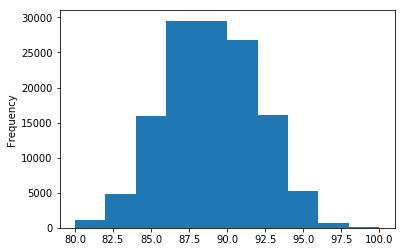

In [18]:
wine['points'].plot(kind='hist')